<a id="0"></a>
# Table of Contents

* [Part 1](#part1)
* [Part 2](#part2)
* [Part 3](#part3)

In [2]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import kaleido

In [3]:
engine = create_engine("mssql+pyodbc://localhost/AdventureWorks2022?trusted_connection=yes&Encrypt=no&driver=ODBC+Driver+18+for+SQL+Server")
connection = engine.connect()

## <a class="anchor" id="part1">Part 1</a>
[back to top](#0)

Employees with pay rate increases:

In [4]:
pay_increases = pd.read_sql(sql="""
SELECT
	e.BusinessEntityID,
	e.JobTitle,
	MIN(h.Rate) AS "Starting rate",
	MAX(h.Rate) AS "Current rate",
	COUNT(h.RateChangeDate) -1 AS "Number of pay increases",
 	e.HireDate,
	MAX(h.RateChangeDate) AS "Last pay increase"

FROM HumanResources.Employee AS e LEFT JOIN HumanResources.EmployeePayHistory AS h
	ON e.BusinessEntityID = h.BusinessEntityID


GROUP BY e.BusinessEntityID, e.JobTitle, e.Gender, e.HireDate
HAVING COUNT(h.RateChangeDate) > 1
ORDER BY "Current Rate" DESC
;
        
""" , con=connection)

pay_increases

,BusinessEntityID,JobTitle,Starting rate,Current rate,Number of pay increases,HireDate,Last pay increase
0,234,Chief Financial Officer,39.06,60.0962,2,2009-01-31,2012-01-29
1,16,Marketing Manager,24.00,37.5000,2,2007-12-20,2012-04-30
2,250,Purchasing Manager,9.86,30.0000,2,2011-02-25,2012-07-14
3,4,Senior Tool Designer,8.62,29.8462,2,2007-12-05,2011-12-15
4,224,Scheduling Assistant,8.62,16.0000,2,2009-01-07,2012-01-01
5,167,Production Technician - WC30,6.50,9.5000,2,2008-12-02,2013-07-14
6,170,Production Technician - WC30,6.50,9.5000,2,2008-12-21,2013-07-14
7,172,Production Technician - WC30,6.50,9.5000,2,2009-01-16,2013-07-14
8,174,Production Technician - WC30,6.75,9.5000,2,2009-01-27,2013-07-14
9,175,Production Technician - WC30,6.50,9.5000,2,2009-02-02,2013-07-14


Average pay rate by department:

In [5]:
pay_rates = pd.read_sql(sql="""
SELECT
	d.Name AS "Department",
	AVG(ph.Rate) AS "Average rate"
	
FROM HumanResources.EmployeePayHistory AS ph
	LEFT JOIN HumanResources.EmployeeDepartmentHistory AS dh
	ON ph.BusinessEntityID = dh.BusinessEntityID
	LEFT JOIN HumanResources.Department AS d
	ON dh.DepartmentID = d.DepartmentID

GROUP BY d.Name
ORDER BY AVG(ph.Rate) DESC
;
        
""" , con=connection)

pay_rates

,Department,Average rate
0,Executive,68.3034
1,Research and Development,43.6731
2,Information Services,34.1586
3,Engineering,33.6723
4,Sales,29.9719
5,Finance,29.7742
6,Tool Design,23.5054
7,Purchasing,20.1489
8,Marketing,18.9364
9,Human Resources,18.0248


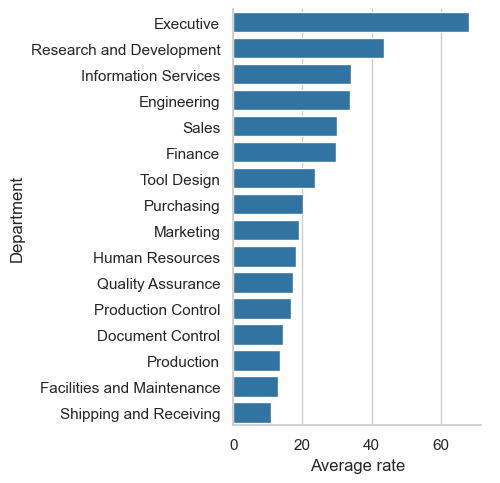

In [6]:
sns.set_context("notebook")
sns.set_style("whitegrid")
sns.catplot(data=pay_rates, x="Average rate", y="Department", kind="bar")

## <a class="anchor" id="part2">Part 2</a>
[back to top](#0)

Where do employees live?

In [7]:
employee_city = pd.read_sql(sql="""
SELECT 
	c.City,
	COUNT(*) AS "Employees by city",
	d.StateProvinceCode AS "State"
	
FROM Person.Person AS a LEFT JOIN Person.BusinessEntityAddress AS b
	ON a.BusinessEntityID = b.BusinessEntityID LEFT JOIN Person.Address AS c
	ON b.AddressID = c.AddressID LEFT JOIN Person.StateProvince AS d
	ON c.StateProvinceID = d.StateProvinceID
WHERE a.PersonType = 'EM'

GROUP BY c.City, d.StateProvinceCode
ORDER BY "Employees by city" DESC
;
""" 
, con=connection)

Chart of employees by city:

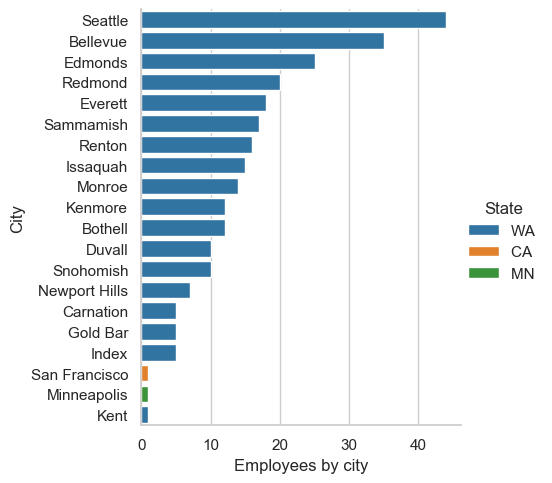

In [8]:
sns.catplot(data=employee_city, x="Employees by city", y="City", kind="bar", hue="State")

In [9]:
employee_state = pd.read_sql(sql="""
SELECT 
	d.StateProvinceCode AS "State",
	COUNT(*) AS "Employees by state"
		
FROM Person.Person AS a LEFT JOIN Person.BusinessEntityAddress AS b
	ON a.BusinessEntityID = b.BusinessEntityID LEFT JOIN Person.Address AS c
	ON b.AddressID = c.AddressID LEFT JOIN Person.StateProvince AS d
	ON c.StateProvinceID = d.StateProvinceID
WHERE a.PersonType = 'EM'

GROUP BY d.StateProvinceCode
ORDER BY "Employees by state" DESC
;
""" , con=connection)

employee_state

,State,Employees by state
0,WA,271
1,CA,1
2,MN,1


Extract geographic coordinates of cities for mapping in three easy steps:
1. list all employees, their city, state, Spatial Location
2. where multiple employees in one city, select one record for each city (it does not actually matter which)
3. extract latitude and longitude from selected Spatial Location for each city

The steps would be easy if ODBC supported geography data type, however, it doesn't. It does not appear to be possible to import Spatial Location into a Pandas data frame.
The following code takes care of the first two steps:


If, however, ODBC supported the Spatial Location data type, the SQL code to return latitude and longitude would be:

As a workaround, I have saved the SQL query results as a csv file and will import it as a data frame and save as a new SQL table.

In [10]:
city_coordinates = pd.read_csv("lat_long_emp_cities.csv", sep=';', names=['city', 'state', 'latitude', 'longitude'])
city_coordinates.to_sql('city_coordinates', con=engine, if_exists='replace', index=False)
employee_city_data = pd.read_sql(sql="""
SELECT 
	c.City,
    d.StateProvinceCode AS "State",
	COUNT(*) AS employees_by_city,
	e.latitude AS "Latitude",
	e.longitude AS "Longitude"
		
FROM Person.Person AS a LEFT JOIN Person.BusinessEntityAddress AS b
	ON a.BusinessEntityID = b.BusinessEntityID LEFT JOIN Person.Address AS c
	ON b.AddressID = c.AddressID LEFT JOIN Person.StateProvince AS d
	ON c.StateProvinceID = d.StateProvinceID LEFT JOIN city_coordinates AS e
	ON c.City = e.city
 
WHERE a.PersonType = 'EM'

GROUP BY c.City, d.StateProvinceCode, e.latitude, e.longitude
ORDER BY employees_by_city DESC
;            
            
""" , con=connection)
employee_city_data

,City,State,employees_by_city,Latitude,Longitude
0,Seattle,WA,44,47.57,-122.23
1,Bellevue,WA,35,47.57,-122.33
2,Edmonds,WA,25,47.77,-122.44
3,Redmond,WA,20,47.64,-122.28
4,Everett,WA,18,47.93,-122.09
5,Sammamish,WA,17,47.68,-121.97
6,Renton,WA,16,47.52,-122.25
7,Issaquah,WA,15,47.55,-122.15
8,Monroe,WA,14,47.82,-121.90
9,Bothell,WA,12,47.79,-122.16


Mapping with plotly:

In [ ]:
fig = px.scatter_map(employee_city_data, lat="Latitude", lon="Longitude", hover_name="City", map_style='light',
                     size="employees_by_city", color="employees_by_city", text="City", 
                     title="Employee locations", center={"lat": 47.68, "lon": -122.0}, width=800, height=600, zoom=8)
fig.update_traces(textposition='top right')

In [ ]:
fig.show()

![image](employee_cities.png)